In [17]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import sys
sys.path.append(r'D:\kasia\tracking\E6_exp\code\tracks_interactions')
from tracks_interactions.db.db_model import NO_PARENT, CellDB, TrackDB
import dask.array as da
import napari
import numpy as np
import os
os.environ['NAPARI_PERFMON'] = '0'
import cv2
import matplotlib.pyplot as plt

In [2]:
# get access to the database
db_path = r'D:\kasia\tracking\E6_exp\double_segmentation_ultrack\Exp6_gardener_example_to_process.db'
engine = create_engine(f'sqlite:///{db_path}')
session = sessionmaker(bind=engine)()

from sqlalchemy import text
session.execute(text("ANALYZE;"))
session.commit()

In [3]:
t=session.query(TrackDB).filter(TrackDB.accepted_tag == True).all()

In [6]:
cells=session.query(CellDB).filter_by(track_id = t[0].track_id).order_by(CellDB.t).all()
cells[0].signals

{'area': 252,
 'ch0_nuc': 3953.1825396825398,
 'ch0_cyto': 2443.0997229916898,
 'ch1_nuc': 1865.5833333333333,
 'ch1_cyto': 273.33240997229916}

In [19]:
signals = []
tag_list = []
for cell_num in range(len(t)):

    # find cell id
    track_id = t[cell_num].track_id

    # get all cells from the track
    cells=session.query(CellDB).filter_by(track_id = track_id).order_by(CellDB.t).all()

    tag = ''
    for cell in cells:
        if cell.tags.get('apoptosis', False):
            tag='_apo'
            break
        if cell.tags.get('mitosis', False):
            tag='_mit'
            break
    

    # get signal
    s = []
    for cell in cells:
        s.append(cell.signals['ch0_cyto']/cell.signals['ch0_nuc'])
    s = np.array(s)

    if len(s) > 50:
        signals.append(s)
        tag_list.append(tag)

In [21]:
max_len = 0
for s in signals:
    max_len = max(max_len, len(s))
print(max_len)

240


In [22]:
signals_apo = [signals[i] for i in range(len(signals)) if tag_list[i] == '_apo']   
print(len(signals_apo))
signals_senes = [signals[i] for i in range(len(signals)) if tag_list[i] == '']
print(len(signals_senes))

9
7


In [33]:
# make a 2D array
signals2D = np.zeros((len(signals_apo)+len(signals_senes), max_len))

i = 0
for s in signals_apo:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

for s in signals_senes:
    start_index = max_len - len(s)  
    signals2D[i, start_index:] = s
    #signals2D[i, :len(s)] = s
    i+=1

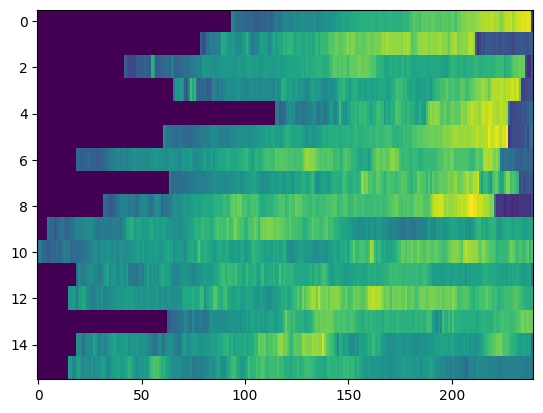

In [34]:
# create a heatmap with matplotlib
plt.imshow(signals2D, aspect='auto', cmap='viridis',interpolation='nearest')
